In [ ]:
!pip install pytorch-ignite tensorboardX ax-platform
!pip install -q -U tensorflow_addons
!pip install jovian --upgrade --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 8.2 MB/s 
     |████████████████████████████████| 125 kB 70.3 MB/s 
     |████████████████████████████████| 993 kB 51.1 MB/s 
     |████████████████████████████████| 363 kB 74.3 MB/s 
     |████████████████████████████████| 361 kB 70.4 MB/s 
     |████████████████████████████████| 713 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 68 kB 2.0 MB/s 


In [ ]:
%%time 
import os
import random
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events, convert_tensor
from ignite.metrics import Accuracy
from ignite.contrib.handlers import TensorboardLogger, ProgressBar
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler, GradsHistHandler, \
    global_step_from_engine

init_notebook_plotting()

[INFO 08-13 15:44:11] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


Downloading and creating PyTorch datasets to load the data

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

CPU times: user 3.57 s, sys: 507 ms, total: 4.08 s
Wall time: 6.26 s


  0%|          | 0/135107811 [00:00<?, ?it/s]

['test', 'train']
['horse', 'bird', 'dog', 'airplane', 'frog', 'deer', 'truck', 'automobile', 'ship', 'cat']


1.   **Use test set for validation:** We'll just use the test set as our validation set rather than reserving a portion (10%, for example) of the data from the training set. Just a little bit more data is now available for training. In general, it is a good idea to retrain the same model on the full dataset merely to give it a modest last performance boost once you have chosen the optimum model architecture and hypeparameters using a defined validation set.

2.   **Channel-Wise data normalization:** By subtracting the mean and dividing by the standard deviation for each channel, we will normalize the image tensors. As a result, each channel's data has a mean of 0 and a standard deviation of 1. In order to avoid values from any one channel from unfairly impacting the losses and gradients during training merely because they are higher or have a larger range of values than others, the data must be normalized.

3.   **Randomized data augmentations:** While importing photos from the practice dataset, we will apply modifications that are randomly selected. To be more precise, we will add 4 pixels to each image before randomly selecting a crop with a size of 32 by 32 pixels and flipping the image horizontally with a 50% chance. Since each time an image is loaded, the modification will be done randomly and dynamically, the model sees slightly different pictures throughout each training period, enhancing its ability to generalize.





In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)]) 
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
print(train_ds)

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


After that, data loaders may be made to retrieve photos in groups. To make better use of more GPU RAM, we'll employ a batch size of 500, which is a considerable amount.

In [ ]:
batch_size = 400

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Here are some examples of photos from the training dataloader that you may look at.

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



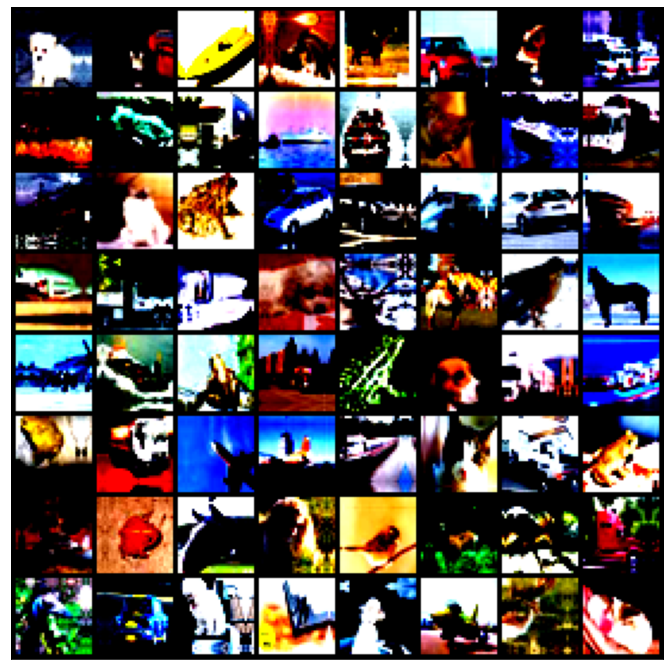

In [ ]:
show_batch(train_dl)

The normalization makes the colors look out of place. Keep in mind that normalization is also used while drawing conclusions. Some of the photographs have been cropped and have had their reflections padded, if you look closely. Visual inspection makes it a little challenging to spot horizontal flip.

**Using a GPU**

We write two helper methods (get default device & to device) and a helper class DeviceDataLoader to transport our model and data to the GPU as needed in order to smoothly use a GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

DeviceDataLoader may now be used to encapsulate our training and validation data loaders for batch data transfers to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

**Model with Residual Blocks and Batch Normalization**

The inclusion of the resudial block, which adds the original input back to the output feature map acquired by passing the input through one or more convolutional layers, is one of the major additions to our CNN model this time.

Here is a very simply Residual block:

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



torch.Size([400, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

**Training the model**

Before training the model, we are going to make a bunch of small but important improvements to our fit function

- **Learning rate scheduling:** We will utilize a learning rate scheduler in place of a set learning rate, which will adjust the learning rate after each batch of training. The "One Cycle Learning Rate Policy" is one of many methods for varying the learning rate during training. It involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of the epochs, then gradually reducing it to a very low value for the remaining epochs.

- **Weight decay:** We also employ weight decay, a regularization method that stops weights from growing out of control by including an extra term in the loss function.

- **Gradient clipping:** In addition to the layer weights and outputs, it is important to keep gradient values within a narrow range to avoid unintended changes in parameters brought on by high gradient values. Gradient clipping is the name of this straightforward yet powerful method.

Let's create the fit_one_cycle function to account for these modifications. The learning rate applied to each batch will also be noted.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.09615384787321091, 'val_loss': 2.315903425216675}]

We may now begin training our model. We will employ the Adam optimizer, which uses strategies like momentum and adjustable learning rates for quicker training, in place of SGD (stochastic gradient descent).

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00393, train_loss: 1.3401, val_loss: 1.2168, val_acc: 0.5939
Epoch [1], last_lr: 0.00935, train_loss: 0.9861, val_loss: 1.9300, val_acc: 0.5271
Epoch [2], last_lr: 0.00972, train_loss: 0.8410, val_loss: 0.9606, val_acc: 0.6979
Epoch [3], last_lr: 0.00812, train_loss: 0.6126, val_loss: 0.7357, val_acc: 0.7488
Epoch [4], last_lr: 0.00556, train_loss: 0.4690, val_loss: 0.4716, val_acc: 0.8406
Epoch [5], last_lr: 0.00283, train_loss: 0.3527, val_loss: 0.3898, val_acc: 0.8654
Epoch [6], last_lr: 0.00077, train_loss: 0.2559, val_loss: 0.2862, val_acc: 0.8993
Epoch [7], last_lr: 0.00000, train_loss: 0.1887, val_loss: 0.2752, val_acc: 0.9069
CPU times: user 41.7 s, sys: 14.4 s, total: 56.1 s
Wall time: 4min 34s


Let's plot the valdation set accuracies to study how the model improves over time.

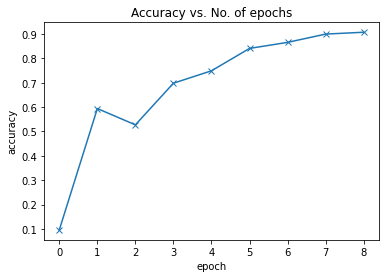

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

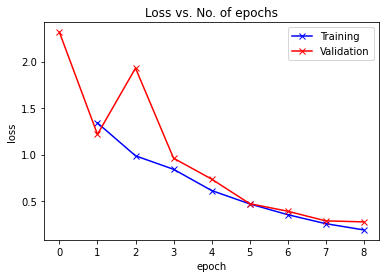

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

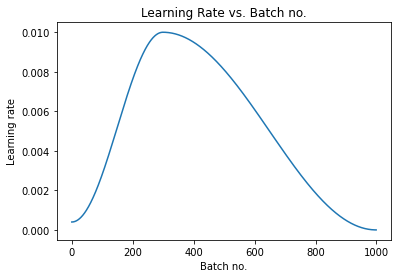

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

The learning rate begins low, climbs progressively for 30% of the iterations to a maximum value of 0.01, then gradually declines to a very low value.

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9069229960441589, 'val_loss': 0.27523815631866455}]

**Hyperparameter Tuning**

I will be doing hyperparameter tuning to different parameters in each iteration of the tuning.


Firstly changing the max_lr to 0.02 to see if it affects the model's accuracy positively

In [ ]:
epochs = 8
max_lr = 0.02
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00786, train_loss: 0.3759, val_loss: 1.4471, val_acc: 0.6204
Epoch [1], last_lr: 0.01871, train_loss: 0.7451, val_loss: 1.2364, val_acc: 0.6290
Epoch [2], last_lr: 0.01944, train_loss: 0.6650, val_loss: 0.7717, val_acc: 0.7386
Epoch [3], last_lr: 0.01623, train_loss: 0.5807, val_loss: 0.6732, val_acc: 0.7749
Epoch [4], last_lr: 0.01112, train_loss: 0.5045, val_loss: 0.5901, val_acc: 0.7996
Epoch [5], last_lr: 0.00566, train_loss: 0.4142, val_loss: 0.4078, val_acc: 0.8601
Epoch [6], last_lr: 0.00153, train_loss: 0.2968, val_loss: 0.3194, val_acc: 0.8908
Epoch [7], last_lr: 0.00000, train_loss: 0.2138, val_loss: 0.2841, val_acc: 0.9031
CPU times: user 41.9 s, sys: 13.9 s, total: 55.8 s
Wall time: 4min 34s


The accuracy has already seen an improvement of 0.01, with no effect of the runtime. I will be adding these tune to my final hyperparameter.

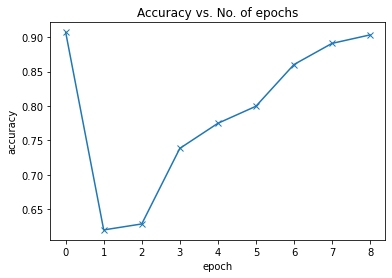

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

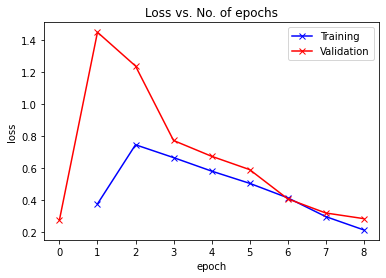

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

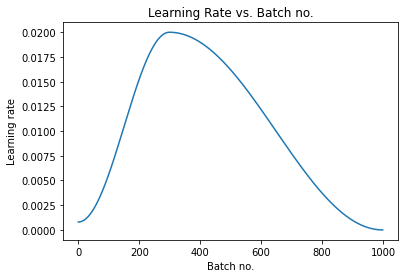

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9030768871307373, 'val_loss': 0.2841382920742035}]

Next I will be checking if gradient clipping affects the model positively, by changing it to 0.2

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00393, train_loss: 0.2235, val_loss: 0.3721, val_acc: 0.8787
Epoch [1], last_lr: 0.00935, train_loss: 0.3818, val_loss: 0.8053, val_acc: 0.7527
Epoch [2], last_lr: 0.00972, train_loss: 0.4352, val_loss: 0.4853, val_acc: 0.8393
Epoch [3], last_lr: 0.00812, train_loss: 0.4026, val_loss: 0.5627, val_acc: 0.8147
Epoch [4], last_lr: 0.00556, train_loss: 0.3399, val_loss: 0.3864, val_acc: 0.8710
Epoch [5], last_lr: 0.00283, train_loss: 0.2813, val_loss: 0.3509, val_acc: 0.8818
Epoch [6], last_lr: 0.00077, train_loss: 0.2048, val_loss: 0.2818, val_acc: 0.9076
Epoch [7], last_lr: 0.00000, train_loss: 0.1574, val_loss: 0.2612, val_acc: 0.9121
CPU times: user 42.2 s, sys: 13.7 s, total: 55.9 s
Wall time: 4min 36s


Again the accuracy of the model increase with no affect to the runtime.

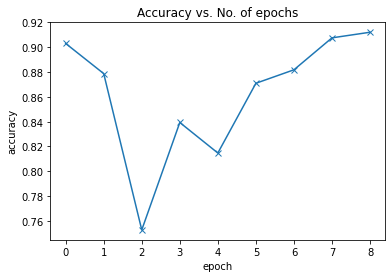

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

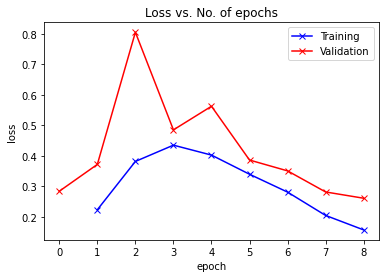

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9121153354644775, 'val_loss': 0.2612060606479645}]

Now I will be checking if weight decay affects the models accuracy, by changing it from 1e-4 to 1e-5

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00393, train_loss: 0.1751, val_loss: 0.4139, val_acc: 0.8690
Epoch [1], last_lr: 0.00935, train_loss: 0.3078, val_loss: 0.4760, val_acc: 0.8491
Epoch [2], last_lr: 0.00972, train_loss: 0.3410, val_loss: 0.3768, val_acc: 0.8744
Epoch [3], last_lr: 0.00812, train_loss: 0.2845, val_loss: 0.4068, val_acc: 0.8635
Epoch [4], last_lr: 0.00556, train_loss: 0.2341, val_loss: 0.3804, val_acc: 0.8798
Epoch [5], last_lr: 0.00283, train_loss: 0.1799, val_loss: 0.3069, val_acc: 0.9045
Epoch [6], last_lr: 0.00077, train_loss: 0.1255, val_loss: 0.2597, val_acc: 0.9172
Epoch [7], last_lr: 0.00000, train_loss: 0.1037, val_loss: 0.2518, val_acc: 0.9207
CPU times: user 41.4 s, sys: 13.6 s, total: 55 s
Wall time: 4min 34s


The increase is significant now compared to the other two parameters, increase of 0.02. And still no affect in runtime

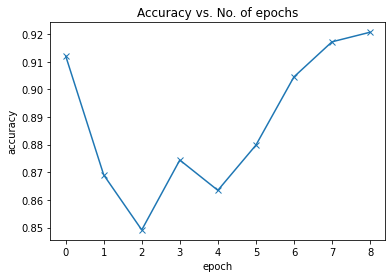

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

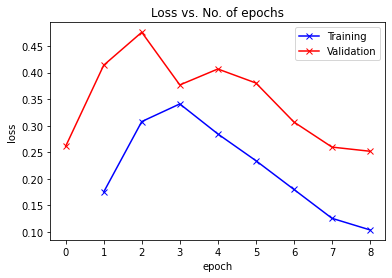

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9206730127334595, 'val_loss': 0.25184547901153564}]

I will next be checking if increasing the amount of epochs will affect the accuracy of the model. Increasing it from 8 to 10

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00278, train_loss: 0.1110, val_loss: 0.3000, val_acc: 0.9074
Epoch [1], last_lr: 0.00759, train_loss: 0.2123, val_loss: 0.6476, val_acc: 0.8095
Epoch [2], last_lr: 0.01000, train_loss: 0.3539, val_loss: 0.5583, val_acc: 0.8154
Epoch [3], last_lr: 0.00950, train_loss: 0.3667, val_loss: 0.5344, val_acc: 0.8181
Epoch [4], last_lr: 0.00812, train_loss: 0.3488, val_loss: 0.3936, val_acc: 0.8690
Epoch [5], last_lr: 0.00611, train_loss: 0.3110, val_loss: 0.5194, val_acc: 0.8295
Epoch [6], last_lr: 0.00389, train_loss: 0.2621, val_loss: 0.3560, val_acc: 0.8798
Epoch [7], last_lr: 0.00188, train_loss: 0.2002, val_loss: 0.2770, val_acc: 0.9075
Epoch [8], last_lr: 0.00050, train_loss: 0.1504, val_loss: 0.2610, val_acc: 0.9145
Epoch [9], last_lr: 0.00000, train_loss: 0.1276, val_loss: 0.2519, val_acc: 0.9166
CPU times: user 51 s, sys: 16.4 s, total: 1min 7s
Wall time: 5min 45s


With the runtime increasing by a whole minute but only increasing the accuracy by 0.02, I am less inclined to include this tuning

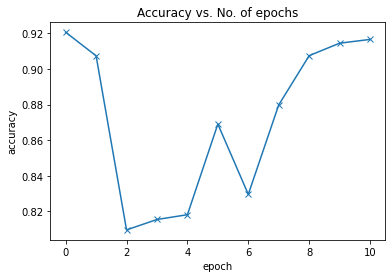

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

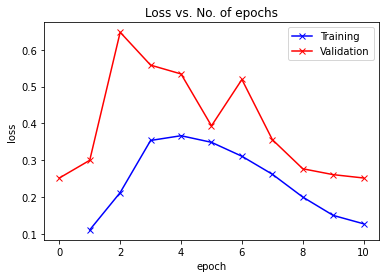

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9166346192359924, 'val_loss': 0.2519376575946808}]

Next I will be checking if a different optimizer function will help the accuracy of model. By checking if Stochastic Gradient Descent is better than the Adam optimizer.

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00393, train_loss: 0.1204, val_loss: 0.2523, val_acc: 0.9158
Epoch [1], last_lr: 0.00935, train_loss: 0.1205, val_loss: 0.2538, val_acc: 0.9159
Epoch [2], last_lr: 0.00972, train_loss: 0.1174, val_loss: 0.2530, val_acc: 0.9157
Epoch [3], last_lr: 0.00812, train_loss: 0.1148, val_loss: 0.2554, val_acc: 0.9155
Epoch [4], last_lr: 0.00556, train_loss: 0.1147, val_loss: 0.2538, val_acc: 0.9188
Epoch [5], last_lr: 0.00283, train_loss: 0.1134, val_loss: 0.2543, val_acc: 0.9183
Epoch [6], last_lr: 0.00077, train_loss: 0.1129, val_loss: 0.2540, val_acc: 0.9187
Epoch [7], last_lr: 0.00000, train_loss: 0.1131, val_loss: 0.2535, val_acc: 0.9186
CPU times: user 32.3 s, sys: 8.99 s, total: 41.3 s
Wall time: 4min 36s


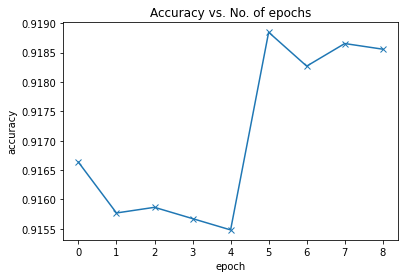

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

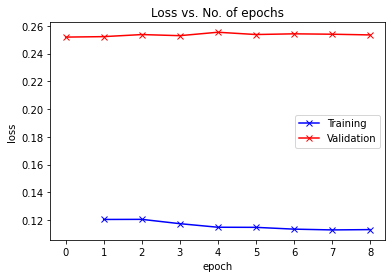

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

Using this optimizer function suggest overfitting in this graph, as the training loss is kept low the whole process while the validation is constantly high. I will not be including this change to the final hyperparamter

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



[{'val_acc': 0.9185577034950256, 'val_loss': 0.25350695848464966}]

i will now be fine tuning the hyperparameter that affect the models accuracy positively. This means tuning the epochs, max learning rate, gradient clipping and weight decay.

In [ ]:
epochs = 10
max_lr = 0.005
grad_clip = 0.4
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch [0], last_lr: 0.00139, train_loss: 0.0261, val_loss: 0.3092, val_acc: 0.9243
Epoch [1], last_lr: 0.00379, train_loss: 0.0553, val_loss: 0.4422, val_acc: 0.8900
Epoch [2], last_lr: 0.00500, train_loss: 0.1327, val_loss: 0.4297, val_acc: 0.8882
Epoch [3], last_lr: 0.00475, train_loss: 0.1185, val_loss: 0.3579, val_acc: 0.9032
Epoch [4], last_lr: 0.00406, train_loss: 0.0938, val_loss: 0.3386, val_acc: 0.9078
Epoch [5], last_lr: 0.00306, train_loss: 0.0722, val_loss: 0.3131, val_acc: 0.9173
Epoch [6], last_lr: 0.00194, train_loss: 0.0511, val_loss: 0.3123, val_acc: 0.9201
Epoch [7], last_lr: 0.00094, train_loss: 0.0366, val_loss: 0.2918, val_acc: 0.9250
Epoch [8], last_lr: 0.00025, train_loss: 0.0296, val_loss: 0.2884, val_acc: 0.9278
Epoch [9], last_lr: 0.00000, train_loss: 0.0274, val_loss: 0.2863, val_acc: 0.9275
CPU times: user 54.9 s, sys: 20.2 s, total: 1min 15s
Wall time: 5min 44s


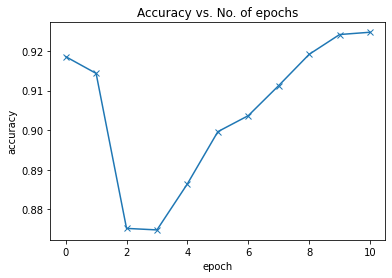

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

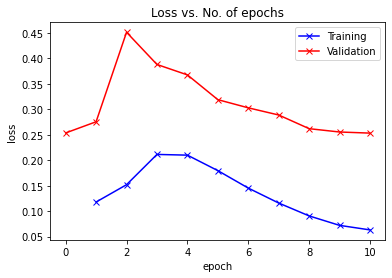

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [ ]:
train_ds1 = ImageFolder(data_dir+'/train', transform=ToTensor())
valid_ds1 = ImageFolder(data_dir+'/test', transform=ToTensor())

Now I will be creating a function to do predictions for a 8 random inputs from the testing dataset

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return valid_ds.classes[preds[0].item()]

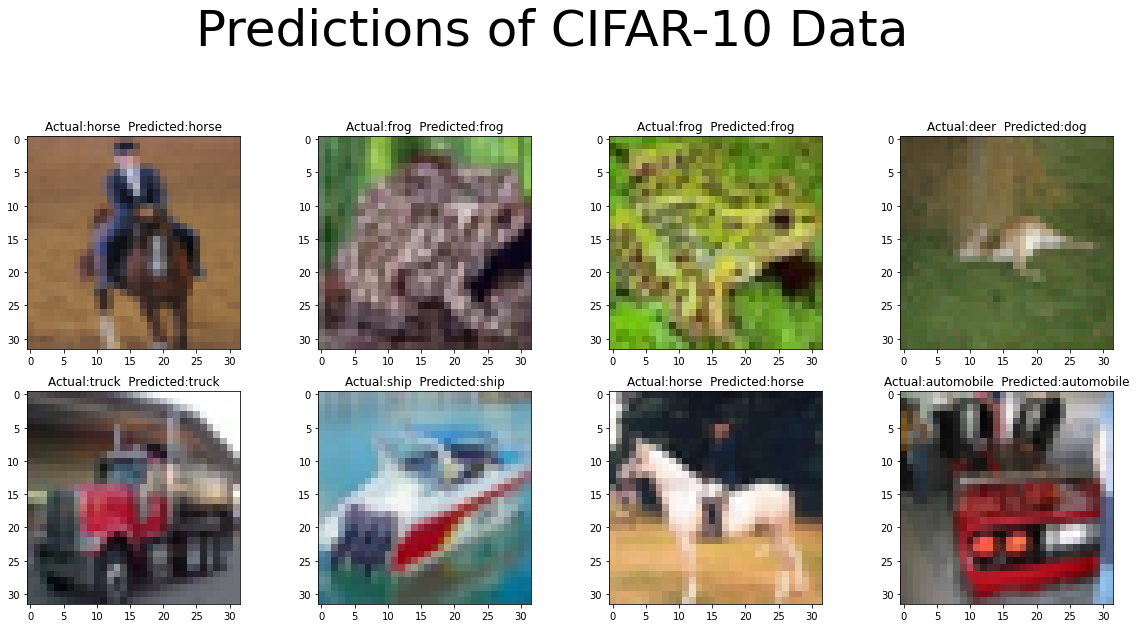

CPU times: user 925 ms, sys: 2.98 ms, total: 928 ms
Wall time: 935 ms


In [ ]:
#To check for predictions with randomized inputs.
%%time
fig=plt.figure(figsize=(20, 18),facecolor='w', edgecolor='k')

for i in range(8):
  img_num = random.randint(1, 10000)
  img2, label2 = valid_ds1[img_num]
  img, label= valid_ds[img_num]
  plt.subplot(4,4,i+1)
  plt.imshow(img2.permute(1, 2, 0))

  plt.title('Actual:'+ valid_ds.classes[label] + '  ' +  'Predicted:'+  predict_image(img, model))
  plt.grid(False)

plt.suptitle("Predictions of CIFAR-10 Data", size=50, color="black")

plt.show()

**Conclusion**

Here is a summary of the different techniques used in this notebook to improve our model performance and reduce the training time:
1. **Data normalization**: By taking away the mean and dividing the standard deviation of the pixels across each channel, we normalized the image tensors. The data is normalized to stop the pixel values from any one channel from adversely impacting the gradients and losses.
2. **Data augmentation**: While importing pictures from the practice dataset, we conducted random alterations. To be more precise, we will add 4 pixels to each image before randomly selecting a crop with a size of 32 x 32 pixels and flipping the image horizontally with a 50% chance.
3. **Residual connections**: The inclusion of the residual block, which returns the original input back to the output feature map created by processing the input through one or more convolutional layers, was one of the major enhancements to our CNN model. The ResNet9 architecture was employed.
4. **Batch normalization**: We added a batch normalization layer, which normalizes the outputs of the preceding layer, after each convolutional layer. The only difference between this and data normalization is that it's applied to a layer's outputs and the mean and standard deviation are learnt parameters.
5. **Learning rate scheduling**: We will utilize a learning rate scheduler in place of a set learning rate, which will adjust the learning rate after each batch of training. We employed the "One Cycle Learning Rate Policy," one of many methods for altering the learning rate during training.
6. **Weight decay**: As yet another regularization method that stops the weights from growing out of control by including an additional term in the loss function, we introduced weight decay to the optimizer.
7. **Gradient clipping**: In order to avoid unintended changes in model parameters brought on by excessive gradient values during training, we have introduced gradient clipping, which helps limit the values of gradients to a limited range.
8. **Adam optimizer**: We employed the Adam optimizer, which employs strategies like momentum and adaptive learning rates for quicker training, in place of SGD (stochastic gradient descent). There are several other optimizers from which to select and experiment.
9. **Hyperparameter tuning**: Tuning hyperparameters to find the optimal hyperparameter to find the best accuracy.

Things that can be improved:


*   **Explore** more **data augmentation** techniques
*   **Try** different **network architecture**
*   **More tuning** on the hyperparameter


 



